# Efficiency and Championships in Major League Baseball (MLB) 1985 - 2013

## December 1, 2015
## Adam Wright
## Udacity Data Science Nanodegree
## Project 2 - Investigate a Dataset

In this study I will examine MLB teams relative efficiency in purchasing wins since 1985. I will also tally teams success  in accruing "Championship Points" (Division Titles, League Championships (i.e. NL or AL Pennant), and World Series Championships) to determine whether there is any correlation between efficiently purchasing wins and winning championships.

This study begins in 1985 as the first season for which full salary data is available in the Lahman database and ends in 2013 - the last year for which said data is fully available. 1985 also falls comfortably under the current iteration of the [reserve clause](http://www.baseball-reference.com/bullpen/Reserve_clause) and the advent of free agency.  Free agency has allowed for much freer movement of veteran players and a reliable indicator of the market wage for those players. This, in turn, has allowed teams much greater latitude in directly purchasing wins compared to previous iterations of the reserve clause. 

All data for this study are derived from the invaluable Lahman Baseball Database maintained by Sean Lahman.

The raw data that I require for this study are located in two seperate .csv files in the Lahman database and I will begin by reading those files in:

In [4]:
import numpy as np
import pandas as pd

teams_csv = 'C:\Users\Adam\Udacity\Data_Analyst_Nanodegree\Project_2\Teams.csv'
salaries_csv = 'C:\Users\Adam\Udacity\Data_Analyst_Nanodegree\Project_2\Salaries.csv'

teams = pd.read_csv(teams_csv)
salaries = pd.read_csv(salaries_csv)

In order to match data by team, by year between the two files, a new, combined key column is created:

In [5]:
teams['year_team'] = teams['yearID'].map(str) + teams['teamID']
salaries['year_team'] = salaries['yearID'].map(str) + salaries['teamID']

Next, the salaries are grouped by the key column and summed by team:

In [6]:
salaries_group = salaries.groupby('year_team').sum()
salaries_group = salaries_group.drop('yearID', 1)

The teams dataframe is pared down to yearID, teamID, the new index, runs scored, runs allowed, division wins, league wins, and World Series wins and this new table is joined with the grouped salary table. 2014 is dropped as there is incomplete salary data for a number of teams (e.g. San Francisco Giants):

In [7]:
teams_v2 = teams[['yearID', 'teamID', 'year_team', 'R', 'RA', 'DivWin', 'LgWin', 'WSWin']]
team_salaries = teams_v2.join(salaries_group, how = 'inner', on = 'year_team')
team_salaries = team_salaries[team_salaries.yearID != 2014]

All of the raw data for the study is now gathered in one place. Next, I calculate each team's [Pythagorean Win Percentage](http://www.fangraphs.com/library/principles/expected-wins-and-losses/) for each season. I use Pythagorean Win Percentage because it is a much better indicator of a team's true talent level than actual won loss record - teams will not be punished or rewarded for luck in this study (essentially normalizes for team's performance in close games).

Now an adjustment has to be made for the number of wins that a team earned versus the plausible minimum number of wins any team possibly could be expected to earn. In baseball analytics, a freely available player (i.e. one who cannot garner a contract above the league mandated minimum) is known as a [Replacement Level Player](http://www.fangraphs.com/library/misc/war/replacement-level/). The archetype for such a player is a freely available veteran minor leaguer of which there are literally hundreds at all times. Because baseball is such a high variance sport, it is estimated that a team composed solely of such freely available players would still have a .294 winning percentage. Thus, in imputing victories purchased due to a team's chosen allocation of resources I will only credit teams for wins above and beyond this theoretical minimum.

Purchased wins, then, are calculated $Purchased Wins = (Pythagorean Win Percentage - 0.294) * 162$

I also calculate "Championship Points" - assigning a value of 3 for Divison Championships, 5 for League Championships, and 7 for World Series Wins. This gives me a measure of the level of success that fans ultimately care about (**flags fly forever!**):

In [8]:
team_salaries['pythag_per'] = team_salaries['R'] ** 2 / (team_salaries['R'] ** 2 + team_salaries['RA'] ** 2)
team_salaries['purchased_wins'] = 162 * (team_salaries['pythag_per'] - 0.294)

team_salaries['DivWin'] = map(lambda x: 1 if x == 'Y' else 0, team_salaries['DivWin'])
team_salaries['LgWin'] = map(lambda x: 1 if x == 'Y' else 0, team_salaries['LgWin'])
team_salaries['WSWin'] = map(lambda x: 1 if x == 'Y' else 0, team_salaries['WSWin'])

team_salaries['champ_points'] = 3 * team_salaries['DivWin'] + 5 * team_salaries['LgWin'] + 7 * team_salaries['WSWin']

Finally, what each team paid per purchased victory in each season is calculated: $Cost Per Win = Team Salary / Purchased Wins$. These scores are then standardized (as z-scores) for comparisons across seasons in very different salary environments:

In [11]:
team_salaries['cost_per_win'] = team_salaries['salary'] / team_salaries['purchased_wins']

team_salaries_mean = team_salaries.groupby('yearID').mean()
team_salaries_std = team_salaries.groupby('yearID').std()
salaries_mean_std = pd.DataFrame({'yearID': range(1985, 2014),
                                   'cost_per_win_mean': team_salaries_mean['cost_per_win'], 
                                   'cost_per_win_std': team_salaries_std['cost_per_win']})

team_salaries_merge = team_salaries.merge(salaries_mean_std, how = 'inner', on = 'yearID')
team_salaries_merge['zcost_per_win'] = ((team_salaries_merge['cost_per_win'] - team_salaries_merge['cost_per_win_mean']) / 
                                        team_salaries_merge['cost_per_win_std'])

team_salaries_merge_mean = team_salaries_merge.groupby('teamID').mean()
team_salaries_merge_sum = team_salaries_merge.groupby('teamID').sum()

efficiency = pd.DataFrame({'zcost_per_win': team_salaries_merge_mean['zcost_per_win'],
                            'championship_points': team_salaries_merge_sum['champ_points'],
                            'mean_salary': team_salaries_merge_mean['salary']})

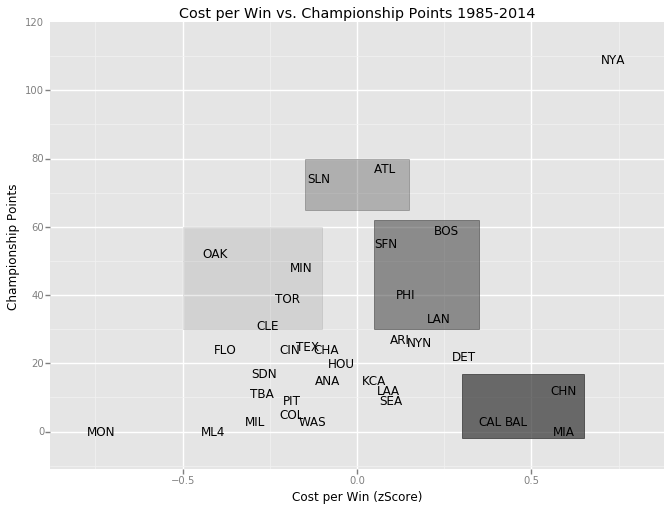

<ggplot: (34869434)>

In [12]:
%matplotlib inline
from ggplot import *

ggplot(aes(x = 'zcost_per_win', y = 'championship_points'), data=efficiency) + \
    geom_text(aes(label=efficiency.index)) + \
    geom_rect(xmin = -0.5, xmax = -0.10, ymin = 30, ymax = 60, alpha = 0.1) + \
    geom_rect(xmin = -0.15, xmax = 0.15, ymin = 65, ymax = 80, alpha = 0.3) + \
    geom_rect(xmin = 0.05, xmax = 0.35, ymin = 30, ymax = 62, alpha = 0.5) + \
    geom_rect(xmin = 0.3, xmax = 0.65, ymin = -2, ymax = 17, alpha = 0.7) + \
    xlab('Cost per Win (zScore)') + ylab('Championship Points') + ggtitle('Cost per Win vs. Championship Points 1985-2014')

In the plot, above, each team's standardized cost per win (where a negative score means the team paid less than the mean per win) is plotted against it's accrued championship points. Four groups of teams, indicated by rectangles of increasing opacity stand out as particularly interesting:

1. **Small Market Heroes:** Oakland, Minnesotta, Toronto and Cleveland have done more with less, accruing 30+ championship points while paying significantly less than mean value per win. Oakland in particular has had spectacular success with limited resources.
2. **Model Franchises:** St. Louis and Atlanta win a lot (more than any team except the Yankees!) and do so while paying right around mean value per win. The success of these franchises can be attributed to excellent management.
3. **Big Market Powerhouses:** Boston, San Francisco, Philadelphia, and Los Angeles Dodgers spend significantly more than the mean value per win but have had significant success over the years. These franchises succesfully leverage their superior resources.
4. **Wasteful Spenders:** California Angels (now Los Angeles Angels, LAA on the plot), Baltimore, Miami (formerly Florida, FLO on plot), and Chicago Cubs spend well above the mean amount per win, yet have very little in terms of Championship points to show for it. These teams have been poorly managed and have had little success despite significant financial advantages.

The two outliers are worth mentioning as well. The most efficient team in the study are the Montreal Expos (MON - since 2005 the Washington Nationals, WAS in the above plot). Starting in the 1980s, the Expos were famous for developing young talent, but due to financial constraints were not able to retain that talent through its prime years (under the current reserve clause players are subject to wage controls for the first six years of their MLB careers after which there are virtually no restrictions on their ability to switch teams and negotiate wages). All these talented young players caused them to massively overperform their miniscule payrolls, but they were never quite able to get over the hump and consistently had to watch Hall of Fame level players (e.g. Tim Raines, Andre Dawson, Gary Carter) leave for nothing in free agency. As the talent pipeline dried up in the late 90s, interest in the team plummeted and it wasn't long before they left for the much bigger market of Washington D.C.

On the opposite end of the spectrum, the New York Yankees (NYA) both paid the most per win and accrued the most championship points by massive amounts. The Yankees combination of market, history, international brand, and more recently broadcast network puts them in a different financial universe compared to the rest of baseball - an advantage that they have ruthelessly exploited for decades.

In [13]:
efficiency_r = round(efficiency['zcost_per_win'].corr(efficiency['championship_points']), 2)

print "Pearson's r for efficiency and championship points is {}.".format(efficiency_r)

Pearson's r for efficiency and championship points is 0.24.


The code above calculates Pearson's correlation coefficient for the standardized cost per win and the accrued championship points. Since a negative standardized cost per win represents a team that more efficiently buys wins, a positive correlation coefficient indicates that as efficiency decreases championship points increase! However, I suspect that this is due to the overwhelming success of the New York Yankees. Below I treat them and the Montreal Expos as outliers and remove them from the calculation:

In [14]:
efficiency_no_outliers = efficiency.drop(['NYA', 'MON'])

efficiency_r = round(efficiency_no_outliers['zcost_per_win'].corr(efficiency_no_outliers['championship_points']), 2)

print "Pearson's r for efficiency and championship points with the outliers removed is {}.".format(efficiency_r)

Pearson's r for efficiency and championship points with the outliers removed is -0.09.


**With the outliers removed, it becomes obvious that there is next to zero correlation (though now at least the correlation coefficient indicates the direction of the relationship that I would hope that it would, i.e. more efficient teams win more championships) between efficiently purchasing wins and winning championships in MLB.** Instead, it is likely that other factors such as overall payroll is more closely correlated with championship level success. However, this study does show that the small market dream of paying discount rates for championship quality teams is possible given excellent management as exemplified by the Oakland Athletics. On the other hand, the Chicago Cubs are living proof that the big market nightmare of overpaying for poor results is all to real.